In [1]:
import torch
from torch import nn
import copy
from collections import deque
import random
from tqdm import tqdm
import gym
import matplotlib.pyplot as plt
from datetime import datetime

# RL Pytorch Master Implementation

In [8]:
import torch
import random
from collections import namedtuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import random
import argparse
import numpy as np
from tensorboardX import SummaryWriter
from machine import Machine
from GymMachEnv import MachineEnv

gamma = 0.95
batch_size = 64
lr = 0.01
#lr = 0.1
initial_exploration = 1000
goal_score = 200
log_interval = 10
update_target = 100
replay_memory_capacity = 10000

In [9]:
Transition = namedtuple('Transition', ('state', 'next_state', 'action', 'reward', 'mask'))

def tensorboard_func(array,name):
    writer = SummaryWriter(name)
    
    for x in array:
        writer.add_scalar('log/Average_score', x[0], x[1])

class Memory(object):
    def __init__(self, capacity):
        self.memory = []
        self.capacity = capacity
        self.position = 0

    def push(self, state, next_state, action, reward, mask):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(Transition(state, next_state, action, reward, mask))
        self.memory[self.position] = Transition(state, next_state, action, reward, mask)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        transitions = random.sample(self.memory, batch_size)
        batch = Transition(*zip(*transitions))
        return batch

    def __len__(self):
        return len(self.memory)

class DoubleDQNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DoubleDQNet, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        qvalue = self.fc3(x)
        return qvalue

    @classmethod
    def train_model(cls, online_net, target_net, optimizer, batch):
        states = torch.stack(batch.state)
        next_states = torch.stack(batch.next_state)
        actions = torch.Tensor(batch.action).float()
        rewards = torch.Tensor(batch.reward)
        masks = torch.Tensor(batch.mask)

        pred = online_net(states).squeeze(1)
        _, action_from_online_net = online_net(next_states).squeeze(1).max(1)
        next_pred = target_net(next_states).squeeze(1)

        pred = torch.sum(pred.mul(actions), dim=1)

        target = rewards + masks * gamma * next_pred.gather(1, action_from_online_net.unsqueeze(1)).squeeze(1)


        loss = F.mse_loss(pred, target.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss

    def get_action(self, input):
        qvalue = self.forward(input)
        _, action = torch.max(qvalue, 1)
        return action.numpy()[0]

def get_action(state, target_net, epsilon, env):
    if np.random.rand() <= epsilon:
        return env.action_space.sample()
    else:
        return target_net.get_action(state)


def update_target_model(online_net, target_net):
    # Target -> Net
    target_net.load_state_dict(online_net.state_dict())
    
def compute_avg_return(environment, policy, num_episodes):
    total_return = 0.0
    for _ in range(num_episodes):
        state = torch.Tensor(environment.reset())
        state = state.unsqueeze(0)
        episode_return = 0.0 
        while not environment.done:
            action = get_action(state, policy, 0.1, environment)
            next_state, reward, done, _ = environment.step(action)
            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)
            state = next_state
            episode_return += reward
        total_return += episode_return   
    avg_return = total_return / num_episodes
    return avg_return# Evaluate the agent's policy once before training.

In [10]:
#Intialise training env
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)


#Initialise evaluation env
machine2 = Machine()
machine2.curr_state = 0
env2 = MachineEnv(machine2)


num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.n
print('state size:', num_inputs)
print('action size:', num_actions)


#Create DQN networks
online_net = DoubleDQNet(num_inputs, num_actions)
target_net = DoubleDQNet(num_inputs, num_actions)
update_target_model(online_net, target_net)


#Intialise optimiser
optimizer = optim.Adam(online_net.parameters(), lr=lr)
#writer = SummaryWriter('logs/Trial_2')



online_net.train() #initialise Q network
target_net.train() #initialise target network
memory = Memory(replay_memory_capacity)
running_score = 0
epsilon = 1.0
steps = 0
loss = 0



state size: 4
action size: 2


<ipython-input-9-f09b10207224>:42: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


In [11]:
tracker = [] #record episodic reward
for e in range(30000):
    done = False

    score = 0
    state = env.reset()
    state = torch.Tensor(state)
    state = state.unsqueeze(0)
    while not done:
        steps += 1
        action = get_action(state, target_net, epsilon, env) #epsilon controls exploration of actions
        next_state, reward, done, _ = env.step(action)

        next_state = torch.Tensor(next_state)
        next_state = next_state.unsqueeze(0)

        mask = 0 if done else 1
        
        action_one_hot = np.zeros(2)
        action_one_hot[action] = 1
        memory.push(state, next_state, action_one_hot, reward, mask)

        score += reward
        state = next_state

        if steps > initial_exploration:#exploration & exploitation, epsilon decay
            epsilon -= 1e-5
            epsilon = max(epsilon, 0.1)

            batch = memory.sample(batch_size)
            loss = DoubleDQNet.train_model(online_net, target_net, optimizer, batch)

            if steps % update_target == 0:
                update_target_model(online_net, target_net)


    if e % log_interval == 0:
        if e == 0: continue
        eval_score = compute_avg_return(env2,online_net,20)  #returns average episodic returns in another simulated environment over 20 runs
        print('{} episode | Ave val score over 20 ep: {:.2f} | epsilon: {:.2f}'.format(
            e, eval_score, epsilon))
        tracker.append([e,eval_score])
#         writer.add_scalar('log/score', float(eval_score), e)
#         writer.add_scalar('log/loss', float(loss), e)

tracker = np.array(tracker)
np.savetxt('default.txt',tracker, delimiter=',',fmt='%s')

10 episode | Ave val score over 20 ep: 2030.00 | epsilon: 1.00
20 episode | Ave val score over 20 ep: 4000.00 | epsilon: 1.00


<ipython-input-9-f09b10207224>:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  actions = torch.Tensor(batch.action).float()


30 episode | Ave val score over 20 ep: 6440.00 | epsilon: 1.00
40 episode | Ave val score over 20 ep: 5750.00 | epsilon: 0.99
50 episode | Ave val score over 20 ep: 6435.00 | epsilon: 0.99
60 episode | Ave val score over 20 ep: 3630.00 | epsilon: 0.98
70 episode | Ave val score over 20 ep: 6790.00 | epsilon: 0.98
80 episode | Ave val score over 20 ep: 5685.00 | epsilon: 0.97
90 episode | Ave val score over 20 ep: 6315.00 | epsilon: 0.97
100 episode | Ave val score over 20 ep: 5090.00 | epsilon: 0.96
110 episode | Ave val score over 20 ep: 8125.00 | epsilon: 0.95
120 episode | Ave val score over 20 ep: 6480.00 | epsilon: 0.95
130 episode | Ave val score over 20 ep: 5270.00 | epsilon: 0.94
140 episode | Ave val score over 20 ep: 5285.00 | epsilon: 0.94
150 episode | Ave val score over 20 ep: 5250.00 | epsilon: 0.94
160 episode | Ave val score over 20 ep: 5160.00 | epsilon: 0.93
170 episode | Ave val score over 20 ep: 7430.00 | epsilon: 0.93
180 episode | Ave val score over 20 ep: 5270.00

1310 episode | Ave val score over 20 ep: 6210.00 | epsilon: 0.51
1320 episode | Ave val score over 20 ep: 5800.00 | epsilon: 0.51
1330 episode | Ave val score over 20 ep: 5855.00 | epsilon: 0.51
1340 episode | Ave val score over 20 ep: 5490.00 | epsilon: 0.50
1350 episode | Ave val score over 20 ep: 5520.00 | epsilon: 0.50
1360 episode | Ave val score over 20 ep: 5175.00 | epsilon: 0.50
1370 episode | Ave val score over 20 ep: 4965.00 | epsilon: 0.50
1380 episode | Ave val score over 20 ep: 5195.00 | epsilon: 0.49
1390 episode | Ave val score over 20 ep: 5040.00 | epsilon: 0.49
1400 episode | Ave val score over 20 ep: 5565.00 | epsilon: 0.49
1410 episode | Ave val score over 20 ep: 6685.00 | epsilon: 0.49
1420 episode | Ave val score over 20 ep: 4620.00 | epsilon: 0.48
1430 episode | Ave val score over 20 ep: 5200.00 | epsilon: 0.48
1440 episode | Ave val score over 20 ep: 6085.00 | epsilon: 0.48
1450 episode | Ave val score over 20 ep: 6950.00 | epsilon: 0.47
1460 episode | Ave val sc

2580 episode | Ave val score over 20 ep: 4230.00 | epsilon: 0.25
2590 episode | Ave val score over 20 ep: 6195.00 | epsilon: 0.25
2600 episode | Ave val score over 20 ep: 6915.00 | epsilon: 0.24
2610 episode | Ave val score over 20 ep: 7105.00 | epsilon: 0.24
2620 episode | Ave val score over 20 ep: 8075.00 | epsilon: 0.24
2630 episode | Ave val score over 20 ep: 10655.00 | epsilon: 0.24
2640 episode | Ave val score over 20 ep: 6635.00 | epsilon: 0.24
2650 episode | Ave val score over 20 ep: 9650.00 | epsilon: 0.23
2660 episode | Ave val score over 20 ep: 6230.00 | epsilon: 0.23
2670 episode | Ave val score over 20 ep: 5335.00 | epsilon: 0.23
2680 episode | Ave val score over 20 ep: 10285.00 | epsilon: 0.23
2690 episode | Ave val score over 20 ep: 12370.00 | epsilon: 0.22
2700 episode | Ave val score over 20 ep: 18195.00 | epsilon: 0.22
2710 episode | Ave val score over 20 ep: 17055.00 | epsilon: 0.22
2720 episode | Ave val score over 20 ep: 25210.00 | epsilon: 0.22
2730 episode | Ave 

3830 episode | Ave val score over 20 ep: 10965.00 | epsilon: 0.10
3840 episode | Ave val score over 20 ep: 17135.00 | epsilon: 0.10
3850 episode | Ave val score over 20 ep: 6915.00 | epsilon: 0.10
3860 episode | Ave val score over 20 ep: 11735.00 | epsilon: 0.10
3870 episode | Ave val score over 20 ep: 13450.00 | epsilon: 0.10
3880 episode | Ave val score over 20 ep: 8540.00 | epsilon: 0.10
3890 episode | Ave val score over 20 ep: 12770.00 | epsilon: 0.10
3900 episode | Ave val score over 20 ep: 8640.00 | epsilon: 0.10
3910 episode | Ave val score over 20 ep: 12270.00 | epsilon: 0.10
3920 episode | Ave val score over 20 ep: 10620.00 | epsilon: 0.10
3930 episode | Ave val score over 20 ep: 10385.00 | epsilon: 0.10
3940 episode | Ave val score over 20 ep: 9785.00 | epsilon: 0.10
3950 episode | Ave val score over 20 ep: 15745.00 | epsilon: 0.10
3960 episode | Ave val score over 20 ep: 12395.00 | epsilon: 0.10
3970 episode | Ave val score over 20 ep: 19115.00 | epsilon: 0.10
3980 episode |

5080 episode | Ave val score over 20 ep: 10050.00 | epsilon: 0.10
5090 episode | Ave val score over 20 ep: 7300.00 | epsilon: 0.10
5100 episode | Ave val score over 20 ep: 9960.00 | epsilon: 0.10
5110 episode | Ave val score over 20 ep: 7695.00 | epsilon: 0.10
5120 episode | Ave val score over 20 ep: 11695.00 | epsilon: 0.10
5130 episode | Ave val score over 20 ep: 10825.00 | epsilon: 0.10
5140 episode | Ave val score over 20 ep: 9695.00 | epsilon: 0.10
5150 episode | Ave val score over 20 ep: 8210.00 | epsilon: 0.10
5160 episode | Ave val score over 20 ep: 16950.00 | epsilon: 0.10
5170 episode | Ave val score over 20 ep: 13470.00 | epsilon: 0.10
5180 episode | Ave val score over 20 ep: 14025.00 | epsilon: 0.10
5190 episode | Ave val score over 20 ep: 14715.00 | epsilon: 0.10
5200 episode | Ave val score over 20 ep: 9395.00 | epsilon: 0.10
5210 episode | Ave val score over 20 ep: 9715.00 | epsilon: 0.10
5220 episode | Ave val score over 20 ep: 18145.00 | epsilon: 0.10
5230 episode | Av

6330 episode | Ave val score over 20 ep: 11270.00 | epsilon: 0.10
6340 episode | Ave val score over 20 ep: 11755.00 | epsilon: 0.10
6350 episode | Ave val score over 20 ep: 17150.00 | epsilon: 0.10
6360 episode | Ave val score over 20 ep: 15355.00 | epsilon: 0.10
6370 episode | Ave val score over 20 ep: 15990.00 | epsilon: 0.10
6380 episode | Ave val score over 20 ep: 9885.00 | epsilon: 0.10
6390 episode | Ave val score over 20 ep: 21070.00 | epsilon: 0.10
6400 episode | Ave val score over 20 ep: 16340.00 | epsilon: 0.10
6410 episode | Ave val score over 20 ep: 26275.00 | epsilon: 0.10
6420 episode | Ave val score over 20 ep: 10340.00 | epsilon: 0.10
6430 episode | Ave val score over 20 ep: 9170.00 | epsilon: 0.10
6440 episode | Ave val score over 20 ep: 9310.00 | epsilon: 0.10
6450 episode | Ave val score over 20 ep: 16255.00 | epsilon: 0.10
6460 episode | Ave val score over 20 ep: 22955.00 | epsilon: 0.10
6470 episode | Ave val score over 20 ep: 9510.00 | epsilon: 0.10
6480 episode |

7580 episode | Ave val score over 20 ep: 7635.00 | epsilon: 0.10
7590 episode | Ave val score over 20 ep: 11325.00 | epsilon: 0.10
7600 episode | Ave val score over 20 ep: 10395.00 | epsilon: 0.10
7610 episode | Ave val score over 20 ep: 8405.00 | epsilon: 0.10
7620 episode | Ave val score over 20 ep: 22360.00 | epsilon: 0.10
7630 episode | Ave val score over 20 ep: 10070.00 | epsilon: 0.10
7640 episode | Ave val score over 20 ep: 14010.00 | epsilon: 0.10
7650 episode | Ave val score over 20 ep: 14555.00 | epsilon: 0.10
7660 episode | Ave val score over 20 ep: 17930.00 | epsilon: 0.10
7670 episode | Ave val score over 20 ep: 11845.00 | epsilon: 0.10
7680 episode | Ave val score over 20 ep: 7400.00 | epsilon: 0.10
7690 episode | Ave val score over 20 ep: 12110.00 | epsilon: 0.10
7700 episode | Ave val score over 20 ep: 9675.00 | epsilon: 0.10
7710 episode | Ave val score over 20 ep: 11250.00 | epsilon: 0.10
7720 episode | Ave val score over 20 ep: 16140.00 | epsilon: 0.10
7730 episode |

8830 episode | Ave val score over 20 ep: 21985.00 | epsilon: 0.10
8840 episode | Ave val score over 20 ep: 12635.00 | epsilon: 0.10
8850 episode | Ave val score over 20 ep: 16960.00 | epsilon: 0.10
8860 episode | Ave val score over 20 ep: 12540.00 | epsilon: 0.10
8870 episode | Ave val score over 20 ep: 10435.00 | epsilon: 0.10
8880 episode | Ave val score over 20 ep: 16530.00 | epsilon: 0.10
8890 episode | Ave val score over 20 ep: 18070.00 | epsilon: 0.10
8900 episode | Ave val score over 20 ep: 20665.00 | epsilon: 0.10
8910 episode | Ave val score over 20 ep: 19230.00 | epsilon: 0.10
8920 episode | Ave val score over 20 ep: 17985.00 | epsilon: 0.10
8930 episode | Ave val score over 20 ep: 14190.00 | epsilon: 0.10
8940 episode | Ave val score over 20 ep: 10175.00 | epsilon: 0.10
8950 episode | Ave val score over 20 ep: 11855.00 | epsilon: 0.10
8960 episode | Ave val score over 20 ep: 12970.00 | epsilon: 0.10
8970 episode | Ave val score over 20 ep: 18580.00 | epsilon: 0.10
8980 episo

10080 episode | Ave val score over 20 ep: 14260.00 | epsilon: 0.10
10090 episode | Ave val score over 20 ep: 9785.00 | epsilon: 0.10
10100 episode | Ave val score over 20 ep: 15895.00 | epsilon: 0.10
10110 episode | Ave val score over 20 ep: 13280.00 | epsilon: 0.10
10120 episode | Ave val score over 20 ep: 11285.00 | epsilon: 0.10
10130 episode | Ave val score over 20 ep: 16295.00 | epsilon: 0.10
10140 episode | Ave val score over 20 ep: 15260.00 | epsilon: 0.10
10150 episode | Ave val score over 20 ep: 15705.00 | epsilon: 0.10
10160 episode | Ave val score over 20 ep: 18975.00 | epsilon: 0.10
10170 episode | Ave val score over 20 ep: 17145.00 | epsilon: 0.10
10180 episode | Ave val score over 20 ep: 9690.00 | epsilon: 0.10
10190 episode | Ave val score over 20 ep: 18910.00 | epsilon: 0.10
10200 episode | Ave val score over 20 ep: 18890.00 | epsilon: 0.10
10210 episode | Ave val score over 20 ep: 21470.00 | epsilon: 0.10
10220 episode | Ave val score over 20 ep: 14915.00 | epsilon: 0.

11310 episode | Ave val score over 20 ep: 10020.00 | epsilon: 0.10
11320 episode | Ave val score over 20 ep: 12475.00 | epsilon: 0.10
11330 episode | Ave val score over 20 ep: 20025.00 | epsilon: 0.10
11340 episode | Ave val score over 20 ep: 26120.00 | epsilon: 0.10
11350 episode | Ave val score over 20 ep: 19530.00 | epsilon: 0.10
11360 episode | Ave val score over 20 ep: 16170.00 | epsilon: 0.10
11370 episode | Ave val score over 20 ep: 18655.00 | epsilon: 0.10
11380 episode | Ave val score over 20 ep: 18370.00 | epsilon: 0.10
11390 episode | Ave val score over 20 ep: 17465.00 | epsilon: 0.10
11400 episode | Ave val score over 20 ep: 12425.00 | epsilon: 0.10
11410 episode | Ave val score over 20 ep: 14735.00 | epsilon: 0.10
11420 episode | Ave val score over 20 ep: 13770.00 | epsilon: 0.10
11430 episode | Ave val score over 20 ep: 7740.00 | epsilon: 0.10
11440 episode | Ave val score over 20 ep: 8310.00 | epsilon: 0.10
11450 episode | Ave val score over 20 ep: 12980.00 | epsilon: 0.

12540 episode | Ave val score over 20 ep: 20445.00 | epsilon: 0.10
12550 episode | Ave val score over 20 ep: 14930.00 | epsilon: 0.10
12560 episode | Ave val score over 20 ep: 12700.00 | epsilon: 0.10
12570 episode | Ave val score over 20 ep: 7125.00 | epsilon: 0.10
12580 episode | Ave val score over 20 ep: 15615.00 | epsilon: 0.10
12590 episode | Ave val score over 20 ep: 7450.00 | epsilon: 0.10
12600 episode | Ave val score over 20 ep: 11435.00 | epsilon: 0.10
12610 episode | Ave val score over 20 ep: 14860.00 | epsilon: 0.10
12620 episode | Ave val score over 20 ep: 9000.00 | epsilon: 0.10
12630 episode | Ave val score over 20 ep: 11990.00 | epsilon: 0.10
12640 episode | Ave val score over 20 ep: 15620.00 | epsilon: 0.10
12650 episode | Ave val score over 20 ep: 11565.00 | epsilon: 0.10
12660 episode | Ave val score over 20 ep: 15120.00 | epsilon: 0.10
12670 episode | Ave val score over 20 ep: 12870.00 | epsilon: 0.10
12680 episode | Ave val score over 20 ep: 10975.00 | epsilon: 0.1

13770 episode | Ave val score over 20 ep: 12180.00 | epsilon: 0.10
13780 episode | Ave val score over 20 ep: 15585.00 | epsilon: 0.10
13790 episode | Ave val score over 20 ep: 11115.00 | epsilon: 0.10
13800 episode | Ave val score over 20 ep: 18530.00 | epsilon: 0.10
13810 episode | Ave val score over 20 ep: 19085.00 | epsilon: 0.10
13820 episode | Ave val score over 20 ep: 14750.00 | epsilon: 0.10
13830 episode | Ave val score over 20 ep: 20135.00 | epsilon: 0.10
13840 episode | Ave val score over 20 ep: 16695.00 | epsilon: 0.10
13850 episode | Ave val score over 20 ep: 19380.00 | epsilon: 0.10
13860 episode | Ave val score over 20 ep: 19630.00 | epsilon: 0.10
13870 episode | Ave val score over 20 ep: 17150.00 | epsilon: 0.10
13880 episode | Ave val score over 20 ep: 11720.00 | epsilon: 0.10
13890 episode | Ave val score over 20 ep: 13440.00 | epsilon: 0.10
13900 episode | Ave val score over 20 ep: 12825.00 | epsilon: 0.10
13910 episode | Ave val score over 20 ep: 15555.00 | epsilon: 

15000 episode | Ave val score over 20 ep: 14300.00 | epsilon: 0.10
15010 episode | Ave val score over 20 ep: 15235.00 | epsilon: 0.10
15020 episode | Ave val score over 20 ep: 18560.00 | epsilon: 0.10
15030 episode | Ave val score over 20 ep: 7225.00 | epsilon: 0.10
15040 episode | Ave val score over 20 ep: 14075.00 | epsilon: 0.10
15050 episode | Ave val score over 20 ep: 9045.00 | epsilon: 0.10
15060 episode | Ave val score over 20 ep: 11680.00 | epsilon: 0.10
15070 episode | Ave val score over 20 ep: 11705.00 | epsilon: 0.10
15080 episode | Ave val score over 20 ep: 10905.00 | epsilon: 0.10
15090 episode | Ave val score over 20 ep: 15530.00 | epsilon: 0.10
15100 episode | Ave val score over 20 ep: 17480.00 | epsilon: 0.10
15110 episode | Ave val score over 20 ep: 20940.00 | epsilon: 0.10
15120 episode | Ave val score over 20 ep: 12440.00 | epsilon: 0.10
15130 episode | Ave val score over 20 ep: 11415.00 | epsilon: 0.10
15140 episode | Ave val score over 20 ep: 13590.00 | epsilon: 0.

16230 episode | Ave val score over 20 ep: 10800.00 | epsilon: 0.10
16240 episode | Ave val score over 20 ep: 7955.00 | epsilon: 0.10
16250 episode | Ave val score over 20 ep: 19925.00 | epsilon: 0.10
16260 episode | Ave val score over 20 ep: 17580.00 | epsilon: 0.10
16270 episode | Ave val score over 20 ep: 19155.00 | epsilon: 0.10
16280 episode | Ave val score over 20 ep: 9855.00 | epsilon: 0.10
16290 episode | Ave val score over 20 ep: 16255.00 | epsilon: 0.10
16300 episode | Ave val score over 20 ep: 14730.00 | epsilon: 0.10
16310 episode | Ave val score over 20 ep: 14595.00 | epsilon: 0.10
16320 episode | Ave val score over 20 ep: 11180.00 | epsilon: 0.10
16330 episode | Ave val score over 20 ep: 20100.00 | epsilon: 0.10
16340 episode | Ave val score over 20 ep: 21865.00 | epsilon: 0.10
16350 episode | Ave val score over 20 ep: 23280.00 | epsilon: 0.10
16360 episode | Ave val score over 20 ep: 10090.00 | epsilon: 0.10
16370 episode | Ave val score over 20 ep: 7625.00 | epsilon: 0.1

17460 episode | Ave val score over 20 ep: 17860.00 | epsilon: 0.10
17470 episode | Ave val score over 20 ep: 17190.00 | epsilon: 0.10
17480 episode | Ave val score over 20 ep: 16830.00 | epsilon: 0.10
17490 episode | Ave val score over 20 ep: 15900.00 | epsilon: 0.10
17500 episode | Ave val score over 20 ep: 9115.00 | epsilon: 0.10
17510 episode | Ave val score over 20 ep: 21815.00 | epsilon: 0.10
17520 episode | Ave val score over 20 ep: 12575.00 | epsilon: 0.10
17530 episode | Ave val score over 20 ep: 15475.00 | epsilon: 0.10
17540 episode | Ave val score over 20 ep: 14730.00 | epsilon: 0.10
17550 episode | Ave val score over 20 ep: 18715.00 | epsilon: 0.10
17560 episode | Ave val score over 20 ep: 7560.00 | epsilon: 0.10
17570 episode | Ave val score over 20 ep: 8225.00 | epsilon: 0.10
17580 episode | Ave val score over 20 ep: 21360.00 | epsilon: 0.10
17590 episode | Ave val score over 20 ep: 20500.00 | epsilon: 0.10
17600 episode | Ave val score over 20 ep: 12125.00 | epsilon: 0.1

18690 episode | Ave val score over 20 ep: 15255.00 | epsilon: 0.10
18700 episode | Ave val score over 20 ep: 13380.00 | epsilon: 0.10
18710 episode | Ave val score over 20 ep: 12935.00 | epsilon: 0.10
18720 episode | Ave val score over 20 ep: 17165.00 | epsilon: 0.10
18730 episode | Ave val score over 20 ep: 20000.00 | epsilon: 0.10
18740 episode | Ave val score over 20 ep: 14355.00 | epsilon: 0.10
18750 episode | Ave val score over 20 ep: 20690.00 | epsilon: 0.10
18760 episode | Ave val score over 20 ep: 16385.00 | epsilon: 0.10
18770 episode | Ave val score over 20 ep: 20335.00 | epsilon: 0.10
18780 episode | Ave val score over 20 ep: 8100.00 | epsilon: 0.10
18790 episode | Ave val score over 20 ep: 12060.00 | epsilon: 0.10
18800 episode | Ave val score over 20 ep: 11450.00 | epsilon: 0.10
18810 episode | Ave val score over 20 ep: 12175.00 | epsilon: 0.10
18820 episode | Ave val score over 20 ep: 15655.00 | epsilon: 0.10
18830 episode | Ave val score over 20 ep: 10665.00 | epsilon: 0

19920 episode | Ave val score over 20 ep: 12720.00 | epsilon: 0.10
19930 episode | Ave val score over 20 ep: 9900.00 | epsilon: 0.10
19940 episode | Ave val score over 20 ep: 12325.00 | epsilon: 0.10
19950 episode | Ave val score over 20 ep: 12755.00 | epsilon: 0.10
19960 episode | Ave val score over 20 ep: 17025.00 | epsilon: 0.10
19970 episode | Ave val score over 20 ep: 16935.00 | epsilon: 0.10
19980 episode | Ave val score over 20 ep: 19715.00 | epsilon: 0.10
19990 episode | Ave val score over 20 ep: 17760.00 | epsilon: 0.10
20000 episode | Ave val score over 20 ep: 10990.00 | epsilon: 0.10
20010 episode | Ave val score over 20 ep: 9135.00 | epsilon: 0.10
20020 episode | Ave val score over 20 ep: 21355.00 | epsilon: 0.10
20030 episode | Ave val score over 20 ep: 10865.00 | epsilon: 0.10
20040 episode | Ave val score over 20 ep: 9390.00 | epsilon: 0.10
20050 episode | Ave val score over 20 ep: 10085.00 | epsilon: 0.10
20060 episode | Ave val score over 20 ep: 11535.00 | epsilon: 0.1

21150 episode | Ave val score over 20 ep: 14210.00 | epsilon: 0.10
21160 episode | Ave val score over 20 ep: 14180.00 | epsilon: 0.10
21170 episode | Ave val score over 20 ep: 8350.00 | epsilon: 0.10
21180 episode | Ave val score over 20 ep: 11705.00 | epsilon: 0.10
21190 episode | Ave val score over 20 ep: 6570.00 | epsilon: 0.10
21200 episode | Ave val score over 20 ep: 10240.00 | epsilon: 0.10
21210 episode | Ave val score over 20 ep: 10300.00 | epsilon: 0.10
21220 episode | Ave val score over 20 ep: 7940.00 | epsilon: 0.10
21230 episode | Ave val score over 20 ep: 11325.00 | epsilon: 0.10
21240 episode | Ave val score over 20 ep: 11855.00 | epsilon: 0.10
21250 episode | Ave val score over 20 ep: 9550.00 | epsilon: 0.10
21260 episode | Ave val score over 20 ep: 12835.00 | epsilon: 0.10
21270 episode | Ave val score over 20 ep: 9140.00 | epsilon: 0.10
21280 episode | Ave val score over 20 ep: 19280.00 | epsilon: 0.10
21290 episode | Ave val score over 20 ep: 10290.00 | epsilon: 0.10


22380 episode | Ave val score over 20 ep: 10065.00 | epsilon: 0.10
22390 episode | Ave val score over 20 ep: 16050.00 | epsilon: 0.10
22400 episode | Ave val score over 20 ep: 9375.00 | epsilon: 0.10
22410 episode | Ave val score over 20 ep: 11715.00 | epsilon: 0.10
22420 episode | Ave val score over 20 ep: 12450.00 | epsilon: 0.10
22430 episode | Ave val score over 20 ep: 21320.00 | epsilon: 0.10
22440 episode | Ave val score over 20 ep: 22350.00 | epsilon: 0.10
22450 episode | Ave val score over 20 ep: 17680.00 | epsilon: 0.10
22460 episode | Ave val score over 20 ep: 8945.00 | epsilon: 0.10
22470 episode | Ave val score over 20 ep: 24925.00 | epsilon: 0.10
22480 episode | Ave val score over 20 ep: 15760.00 | epsilon: 0.10
22490 episode | Ave val score over 20 ep: 12515.00 | epsilon: 0.10
22500 episode | Ave val score over 20 ep: 11780.00 | epsilon: 0.10
22510 episode | Ave val score over 20 ep: 12545.00 | epsilon: 0.10
22520 episode | Ave val score over 20 ep: 10335.00 | epsilon: 0.

23610 episode | Ave val score over 20 ep: 9810.00 | epsilon: 0.10
23620 episode | Ave val score over 20 ep: 12525.00 | epsilon: 0.10
23630 episode | Ave val score over 20 ep: 9270.00 | epsilon: 0.10
23640 episode | Ave val score over 20 ep: 14035.00 | epsilon: 0.10
23650 episode | Ave val score over 20 ep: 16170.00 | epsilon: 0.10
23660 episode | Ave val score over 20 ep: 14240.00 | epsilon: 0.10
23670 episode | Ave val score over 20 ep: 19240.00 | epsilon: 0.10
23680 episode | Ave val score over 20 ep: 14700.00 | epsilon: 0.10
23690 episode | Ave val score over 20 ep: 12310.00 | epsilon: 0.10
23700 episode | Ave val score over 20 ep: 15290.00 | epsilon: 0.10
23710 episode | Ave val score over 20 ep: 23685.00 | epsilon: 0.10
23720 episode | Ave val score over 20 ep: 12825.00 | epsilon: 0.10
23730 episode | Ave val score over 20 ep: 8980.00 | epsilon: 0.10
23740 episode | Ave val score over 20 ep: 14145.00 | epsilon: 0.10
23750 episode | Ave val score over 20 ep: 15180.00 | epsilon: 0.1

24840 episode | Ave val score over 20 ep: 15430.00 | epsilon: 0.10
24850 episode | Ave val score over 20 ep: 10855.00 | epsilon: 0.10
24860 episode | Ave val score over 20 ep: 10530.00 | epsilon: 0.10
24870 episode | Ave val score over 20 ep: 16795.00 | epsilon: 0.10
24880 episode | Ave val score over 20 ep: 11435.00 | epsilon: 0.10
24890 episode | Ave val score over 20 ep: 12450.00 | epsilon: 0.10
24900 episode | Ave val score over 20 ep: 23185.00 | epsilon: 0.10
24910 episode | Ave val score over 20 ep: 17250.00 | epsilon: 0.10
24920 episode | Ave val score over 20 ep: 22265.00 | epsilon: 0.10
24930 episode | Ave val score over 20 ep: 10105.00 | epsilon: 0.10
24940 episode | Ave val score over 20 ep: 9910.00 | epsilon: 0.10
24950 episode | Ave val score over 20 ep: 17730.00 | epsilon: 0.10
24960 episode | Ave val score over 20 ep: 17870.00 | epsilon: 0.10
24970 episode | Ave val score over 20 ep: 13955.00 | epsilon: 0.10
24980 episode | Ave val score over 20 ep: 14205.00 | epsilon: 0

26070 episode | Ave val score over 20 ep: 13880.00 | epsilon: 0.10
26080 episode | Ave val score over 20 ep: 23425.00 | epsilon: 0.10
26090 episode | Ave val score over 20 ep: 21305.00 | epsilon: 0.10
26100 episode | Ave val score over 20 ep: 9430.00 | epsilon: 0.10
26110 episode | Ave val score over 20 ep: 19005.00 | epsilon: 0.10
26120 episode | Ave val score over 20 ep: 12165.00 | epsilon: 0.10
26130 episode | Ave val score over 20 ep: 15295.00 | epsilon: 0.10
26140 episode | Ave val score over 20 ep: 14190.00 | epsilon: 0.10
26150 episode | Ave val score over 20 ep: 14665.00 | epsilon: 0.10
26160 episode | Ave val score over 20 ep: 13105.00 | epsilon: 0.10
26170 episode | Ave val score over 20 ep: 12150.00 | epsilon: 0.10
26180 episode | Ave val score over 20 ep: 18240.00 | epsilon: 0.10
26190 episode | Ave val score over 20 ep: 12780.00 | epsilon: 0.10
26200 episode | Ave val score over 20 ep: 9175.00 | epsilon: 0.10
26210 episode | Ave val score over 20 ep: 11565.00 | epsilon: 0.

27300 episode | Ave val score over 20 ep: 12085.00 | epsilon: 0.10
27310 episode | Ave val score over 20 ep: 10070.00 | epsilon: 0.10
27320 episode | Ave val score over 20 ep: 10650.00 | epsilon: 0.10
27330 episode | Ave val score over 20 ep: 9055.00 | epsilon: 0.10
27340 episode | Ave val score over 20 ep: 18945.00 | epsilon: 0.10
27350 episode | Ave val score over 20 ep: 20765.00 | epsilon: 0.10
27360 episode | Ave val score over 20 ep: 7440.00 | epsilon: 0.10
27370 episode | Ave val score over 20 ep: 16945.00 | epsilon: 0.10
27380 episode | Ave val score over 20 ep: 12120.00 | epsilon: 0.10
27390 episode | Ave val score over 20 ep: 8300.00 | epsilon: 0.10
27400 episode | Ave val score over 20 ep: 13650.00 | epsilon: 0.10
27410 episode | Ave val score over 20 ep: 16440.00 | epsilon: 0.10
27420 episode | Ave val score over 20 ep: 13450.00 | epsilon: 0.10
27430 episode | Ave val score over 20 ep: 15195.00 | epsilon: 0.10
27440 episode | Ave val score over 20 ep: 18080.00 | epsilon: 0.1

28530 episode | Ave val score over 20 ep: 9585.00 | epsilon: 0.10
28540 episode | Ave val score over 20 ep: 10270.00 | epsilon: 0.10
28550 episode | Ave val score over 20 ep: 14205.00 | epsilon: 0.10
28560 episode | Ave val score over 20 ep: 20660.00 | epsilon: 0.10
28570 episode | Ave val score over 20 ep: 17485.00 | epsilon: 0.10
28580 episode | Ave val score over 20 ep: 13575.00 | epsilon: 0.10
28590 episode | Ave val score over 20 ep: 17535.00 | epsilon: 0.10
28600 episode | Ave val score over 20 ep: 16080.00 | epsilon: 0.10
28610 episode | Ave val score over 20 ep: 21935.00 | epsilon: 0.10
28620 episode | Ave val score over 20 ep: 12820.00 | epsilon: 0.10
28630 episode | Ave val score over 20 ep: 12735.00 | epsilon: 0.10
28640 episode | Ave val score over 20 ep: 17730.00 | epsilon: 0.10
28650 episode | Ave val score over 20 ep: 12290.00 | epsilon: 0.10
28660 episode | Ave val score over 20 ep: 17250.00 | epsilon: 0.10
28670 episode | Ave val score over 20 ep: 15255.00 | epsilon: 0

29760 episode | Ave val score over 20 ep: 13110.00 | epsilon: 0.10
29770 episode | Ave val score over 20 ep: 12065.00 | epsilon: 0.10
29780 episode | Ave val score over 20 ep: 9035.00 | epsilon: 0.10
29790 episode | Ave val score over 20 ep: 15040.00 | epsilon: 0.10
29800 episode | Ave val score over 20 ep: 14815.00 | epsilon: 0.10
29810 episode | Ave val score over 20 ep: 12720.00 | epsilon: 0.10
29820 episode | Ave val score over 20 ep: 15230.00 | epsilon: 0.10
29830 episode | Ave val score over 20 ep: 12435.00 | epsilon: 0.10
29840 episode | Ave val score over 20 ep: 14515.00 | epsilon: 0.10
29850 episode | Ave val score over 20 ep: 11340.00 | epsilon: 0.10
29860 episode | Ave val score over 20 ep: 12360.00 | epsilon: 0.10
29870 episode | Ave val score over 20 ep: 13960.00 | epsilon: 0.10
29880 episode | Ave val score over 20 ep: 11390.00 | epsilon: 0.10
29890 episode | Ave val score over 20 ep: 15955.00 | epsilon: 0.10
29900 episode | Ave val score over 20 ep: 18190.00 | epsilon: 0

In [14]:
torch.save(online_net,'default_dqn_agent.pt')

In [17]:
tracker = np.array(tracker)

Text(0, 0.5, 'Average reward')

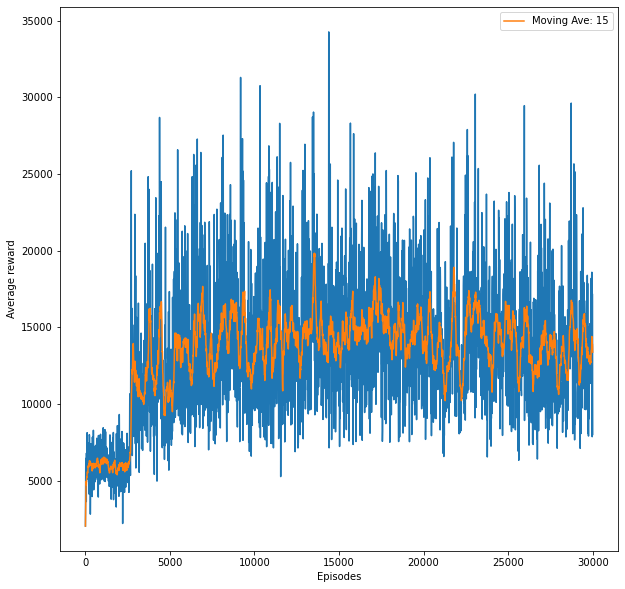

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(tracker)
moving_ave = df.iloc[:,1].rolling(15,min_periods=1).mean().values.flatten().tolist()

fig = plt.figure(figsize=(10,10))
plt.plot(tracker[:,0],tracker[:,1])
plt.plot(tracker[:,0],moving_ave,label='Moving Ave: 15')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Average reward')

In [10]:
np.savetxt('default_params.txt', tracker, fmt='%f')